In [1]:
############################### Organization ################################
#############################################################################

## Import some important libraries
import os, sys, json, time, cv2, skimage, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

## Define root directory of the project
ROOT_DIR = "../Cell_Detection/"
print("Check root directory: ", os.path.exists(ROOT_DIR), "\n") 
assert os.path.exists(ROOT_DIR), "ROOT_DIR does not exist"

## Import some important libraries of Mask R-CNN model 
sys.path.append(ROOT_DIR)
from config import Config
import utils as utils
import visualize
import model as modellib
from model import log
import dataset_preparation

# from mrcnn.config import Config
# import mrcnn.utils as utils
# from mrcnn import visualize
# import mrcnn.model as modellib
# from mrcnn.model import log
# from mrcnn import dataset_preparation

## CPU and GPU verification (numbers) 
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

## Make a directory to save logs, structure of trained model, and trained weights files in h5 format
MODEL_DIR = os.path.join(ROOT_DIR, "Logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_RCNN.h5")

## Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Check root directory:  True 



Using TensorFlow backend.


In [2]:
############################# Model Configuration ###########################
#############################################################################

class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset. Derives from the base Config class and overrides specific values.
    """
    ## Give the configuration a recognizable name
    NAME = "Hadi_33_"

    ## Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    ## Number of classes (including background)
    NUM_CLASSES = 4    # 1 background + 3 cell types

    ## All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    ## The confidence level (IoU) is 70% 
    DETECTION_MIN_CONFIDENCE = 0.70

    ## You can experiment with this number to see if it improves training. It is better to be 1000, but slower. 
    STEPS_PER_EPOCH = 10      

    ## This is how often validation is run. 
    ## If you are using too much hard drive space on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    ## Backbone of the CNN model: "resnet50", "resnet101"  
    BACKBONE = "resnet101"

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    
    #############################################################################
    # If enabled, resizes instance masks to a smaller size to reduce memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    TRAIN_BN = False
    #############################################################################
    
config = CocoSynthConfig()
# config.display()

In [3]:
################################# Datasets ##################################
#############################################################################

## Load train dataset (images and masks)
dataset_train = dataset_preparation.CocoLikeDataset()
dataset_train.load_data("Datasets/Phase1/train/Phase1_train.json", "Datasets/Phase1/train/images")
dataset_train.prepare()

## Load validation dataset (images and masks)
dataset_val = dataset_preparation.CocoLikeDataset()
dataset_val.load_data("Datasets/Phase1/val/Phase1_val.json", "Datasets/Phase1/val/images")
dataset_val.prepare()

## Print name of categories in the train dataset. The BG category refers BACKGROUND.
for name in [("Training", dataset_train)]:
    print("Categories:\n_________________")
    for i, info in enumerate(dataset_train.class_info):
        print("{:3}. {:50}".format(i, info["name"]))

## Showing n samples from Train and Validation dataset.
number_of_samples = 0                    # number of samples in each group
for name, dataset in [("Training", dataset_train), ("Validation", dataset_val)]:
    print("=================>", "Number of", name, "images:\t", "{}".format(len(dataset.image_ids)))
    image_ids = dataset.image_ids[0 : number_of_samples]   
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
        bbox = utils.extract_bboxes(mask)
        print("image_id ", image_id, dataset.image_reference(image_id))
        log("image", image)
        log("mask", mask)
        log("class_ids", class_ids)
        log("bbox", bbox)
        visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, size_of_gt =len(bbox), figsize=(10,10))

Categories:
_________________
  0. BG                                                
  1. Dead                                              
  2. Dying                                             
  3. Live                                              
=================> Number of Training images:	 3
=================> Number of Validation images:	 3


In [4]:
################## Model initializing ##################
########################################################

model = modellib.MaskRCNN(mode = "training", config = config, model_dir = MODEL_DIR)

## Which weights to start with?
init_with = "last"           # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name = True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name = True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    ## Load the last model you trained and continue training
    model_path = str(Path(ROOT_DIR)/"Logs"/"hadi_33_20190819T1103/mask_rcnn_hadi_33__1200.h5")
    assert model_path != "", "Provide path to trained weights"
    model.load_weights(model_path, by_name = True)

###################### Train ######################
###################################################

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,    # fine train:     learning_rate=config.LEARNING_RATE / 10,
            epochs=1201,
            layers="all")
end_train = time.time()
hours = round((end_train - start_train) / 3600, 2)
print("\n", f"Training took {hours} hours")

W0909 16:16:34.294836  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 16:16:34.309836  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 16:16:34.324836  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 16:16:34.340836  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.

Re-starting from epoch 1200

Starting at epoch 1200. LR=0.001

Checkpoint Path: ../Cell_Detection/Logs\hadi_33_20190819T1103\mask_rcnn_hadi_33__{epoch:04d}.h5
In model:  rpn_model


W0909 16:16:42.789991  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\tensorflow\python\ops\g

Epoch 1201/1201
10/10 [==============================] - 57s 6s/step - loss: 0.0722 - rpn_class_loss: 4.1548e-05 - rpn_bbox_loss: 0.0014 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0347 - val_loss: 1.3649 - val_rpn_class_loss: 0.1937 - val_rpn_bbox_loss: 0.2933 - val_mrcnn_class_loss: 0.3513 - val_mrcnn_bbox_loss: 0.1364 - val_mrcnn_mask_loss: 0.3901

 Training took 0.04 hours


W0909 16:18:56.298224  8792 deprecation_wrapper.py:119] From C:\Users\shossei7\Cell_Detection\model.py:704: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0909 16:18:56.364225  8792 deprecation.py:323] From C:\Users\shossei7\Cell_Detection\model.py:756: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  ..\Cell_Detection\Logs\hadi_33_20190819T1103\mask_rcnn_hadi_33__1201.h5
Re-starting from epoch 1201
061 PBS-1 ONL_011.jpeg
067 NA3-1 ONL_011.jpeg
Control 063 ONL_011.jpeg

#################################### Detections ####################################

Predicted class_ids =
 [0.9999976  0.9999957  0.99999523 0.9999918  0.9999796  0.9999685
 0.9999577  0.9999162  0.9998715  0.99984205 0.999818   0.9997801
 0.9997397  0.99965525 0.9996512  0.9996209  0.99954176 0.9993905
 0.9991424  0.9987784  0.9986608  0.9984037  0.99685186 0.9958519
 0.99585176 0.99395776 0.9929335  0.9761569  0.97035146 0.965832
 0.961863   0.95643234 0.95344764 0.9466411  0.92226195 0.9112249
 0.883052   0.8229273  0.7534048 ]

***** Live:		 26
***** Intermediate:	 2
***** Dead:		 11
***** Total counted cells:  39


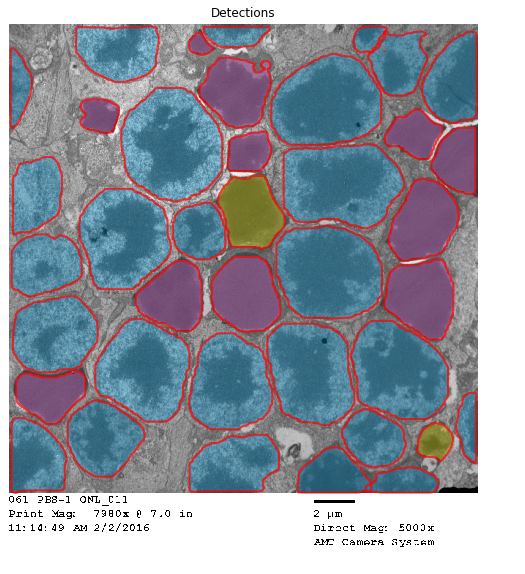

#################################### Ground Truth #########################################

***** Live:		 22
***** Intermediate:	 7
***** Dead:		 8
***** Total counted cells:  37


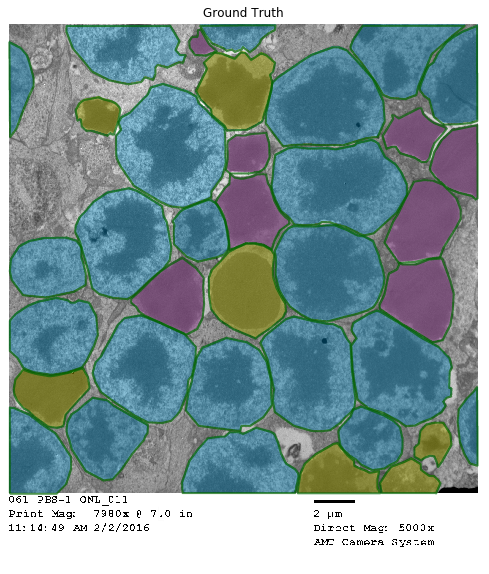

###################################### Mix ############################################

***** Live:		 48
***** Intermediate:	 9
***** Dead:		 19
***** Total counted cells:  76


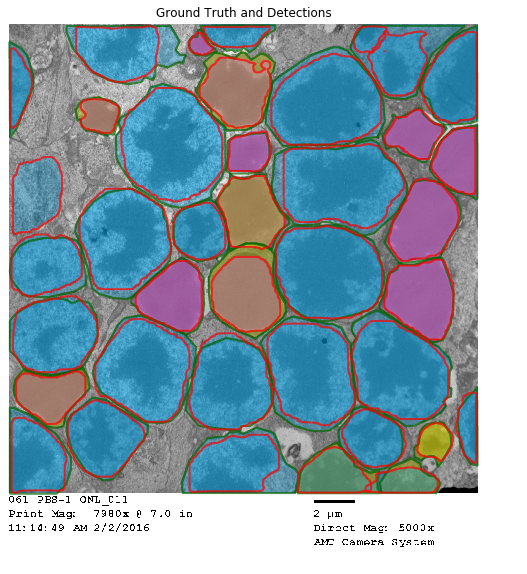

********* mAP = 0.7169079880392741

#################################### Detections ####################################

Predicted class_ids =
 [0.9999938  0.99998915 0.9999851  0.999972   0.9999676  0.9999639
 0.99995804 0.99994445 0.99993753 0.99990785 0.9998865  0.99987054
 0.9998704  0.9998691  0.9998357  0.9997826  0.99977154 0.9996712
 0.9995995  0.99914503 0.9985562  0.99837035 0.99801195 0.9979803
 0.9968117  0.99511683 0.99469614 0.9941507  0.99384475 0.99344045
 0.9916688  0.9826757  0.90670717]

***** Live:		 31
***** Intermediate:	 1
***** Dead:		 1
***** Total counted cells:  33


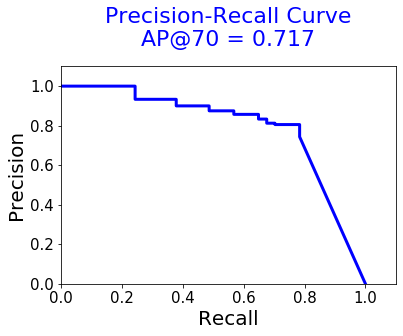

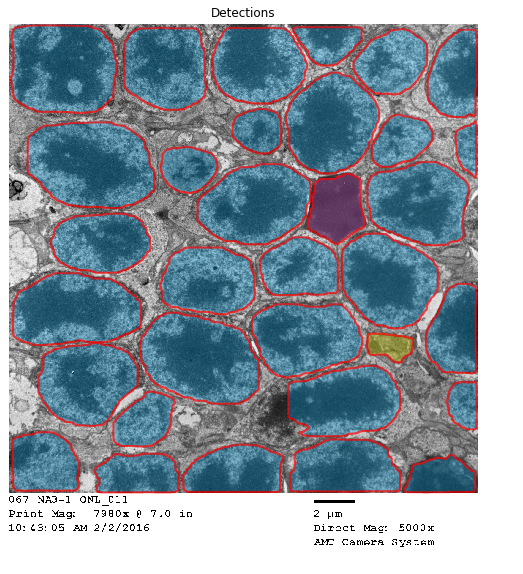

#################################### Ground Truth #########################################

***** Live:		 27
***** Intermediate:	 2
***** Dead:		 0
***** Total counted cells:  29


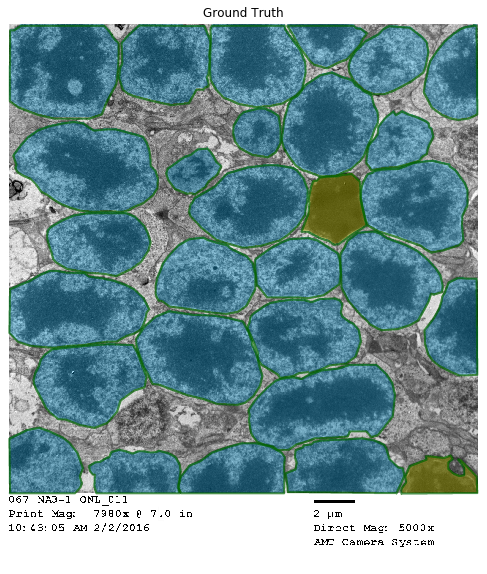

###################################### Mix ############################################

***** Live:		 58
***** Intermediate:	 3
***** Dead:		 1
***** Total counted cells:  62


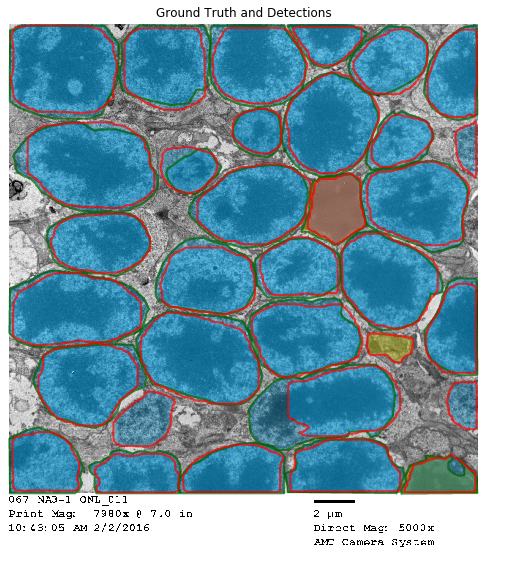

********* mAP = 0.857542449702865

#################################### Detections ####################################

Predicted class_ids =
 [0.988379   0.9790755  0.9664718  0.9657042  0.95614    0.9537029
 0.94872516 0.9412204  0.93477947 0.93160206 0.9315032  0.9309719
 0.92843205 0.9280947  0.92500144 0.9249535  0.9201437  0.91905695
 0.9183382  0.91550076 0.9141814  0.9119654  0.91097337 0.91011864
 0.9091391  0.90893686 0.908529   0.9082443  0.907918   0.9075964
 0.9061433  0.90574205 0.9054925  0.9044654  0.90213305 0.90184695
 0.9006179  0.8995135  0.8989044  0.89707804 0.8897595  0.88960105
 0.8890588  0.8885002  0.8876757  0.88561374 0.88450265 0.87793183
 0.87773514 0.87597024 0.8744207  0.86483395 0.8598634  0.8519354
 0.84193355 0.82026476 0.75720084 0.7389797  0.7008698  0.61559606
 0.6119943 ]

***** Live:		 37
***** Intermediate:	 2
***** Dead:		 22
***** Total counted cells:  61


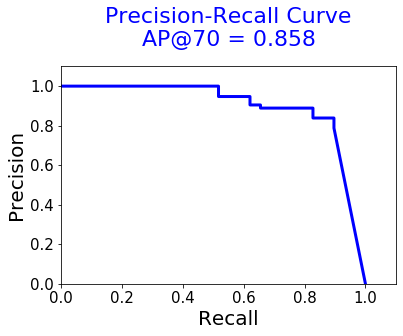

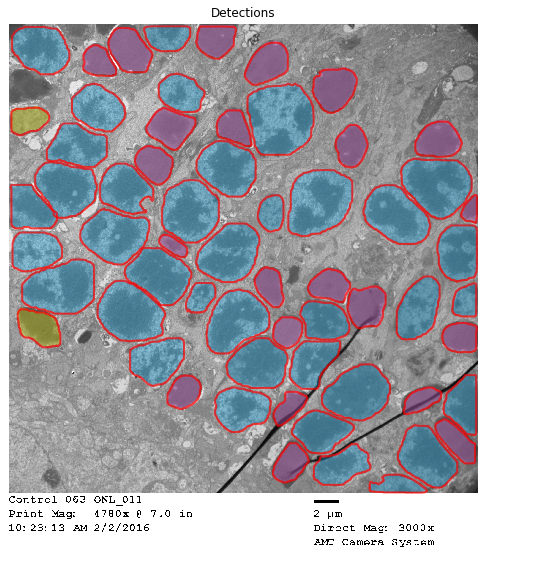

#################################### Ground Truth #########################################

***** Live:		 35
***** Intermediate:	 11
***** Dead:		 20
***** Total counted cells:  66


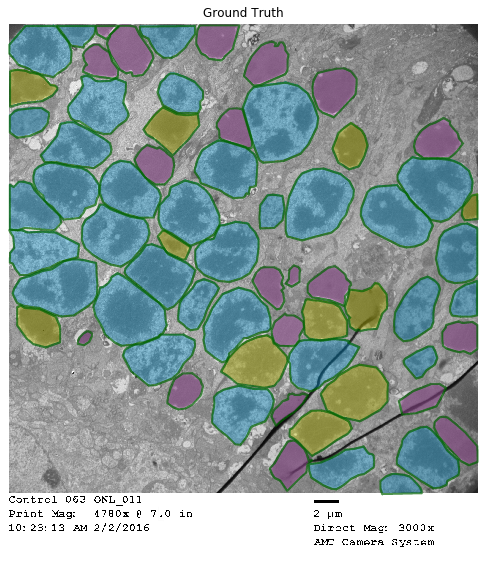

###################################### Mix ############################################

***** Live:		 72
***** Intermediate:	 13
***** Dead:		 42
***** Total counted cells:  127


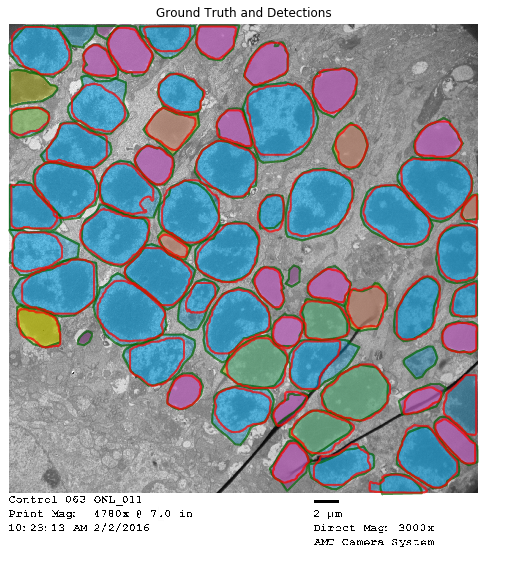

********* mAP = 0.6514070340688425


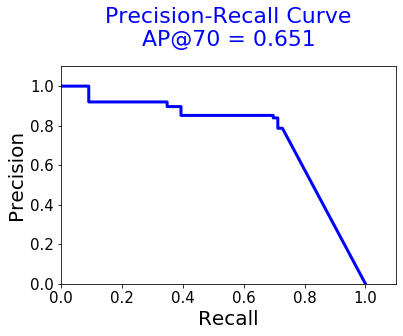

In [5]:
###################### Test ######################
##################################################

class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.50

inference_config = InferenceConfig()
## Recreate the model in inference mode
model = modellib.MaskRCNN(mode = "inference", config = inference_config, model_dir = MODEL_DIR)
## Get path to saved weights (Either set a specific path or find last trained weights)
model_path = str(Path(ROOT_DIR)/"Logs"/"hadi_33_20190819T1103/mask_rcnn_hadi_33__1201.h5")
# model_path = model.find_last()
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name = True)

##################################################

real_test_dir = "Datasets/Phase1/test/images"
image_paths = []
image_id = 0
dataset_val = dataset_preparation.CocoLikeDataset()
dataset_val.load_data("Datasets/Phase1/test/Phase1_test.json", "Datasets/Phase1/test/images")
dataset_val.prepare()
print("=================================")
for filename in os.listdir(real_test_dir):
    print(filename)
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg", ".tif"]:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose = 0)
    Result_pred = results[0]
#     for i in Result_pred:
#         print(i, Result_pred[i].shape)
    print("\n#################################### Detections ####################################\n")
    print("Predicted class_ids =\n", Result_pred["scores"])
    visualize.display_instances(img, Result_pred["rois"], Result_pred["masks"], Result_pred["class_ids"],
                                dataset_train.class_names, Result_pred["scores"], title = "Detections", figsize = (10,10),
                                edgecolor = "red", size_of_gt = len(Result_pred["rois"]))
    print("#################################### Ground Truth #########################################")
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    gt_box = bbox
    gt_mask = mask
    gt_class_id = class_ids
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, title = "Ground Truth", 
                                figsize = (10,10), edgecolor = "darkgreen", size_of_gt = len(gt_box))
    image_id = image_id + 1
    print("###################################### Mix ############################################")
    visualize.display_differences(img, gt_box, gt_class_id, gt_mask, Result_pred["rois"], Result_pred["class_ids"], 
                                  Result_pred["scores"], Result_pred["masks"], dataset_train.class_names, 
                                  title = "Ground Truth and Derection", ax = None, show_mask = True, show_box = True, 
                                  iou_threshold = 0.5, score_threshold = 0.5, size_of_gt =len(gt_box), edgecolor = "darkgreen")
####################################### mAP ##########################################
    Result_metrics = utils.compute_ap(gt_box, gt_class_id, gt_mask, Result_pred["rois"], Result_pred["class_ids"], 
                                      Result_pred["scores"], Result_pred["masks"], iou_threshold = 0.7)
#     print("********* P =", np.mean(Result_metrics[1][1:-2]))
#     print("********* R =", np.mean(Result_metrics[2][1:-2]))
#     print("********* F1-score =", (2 * P * R) / (P + R), "\n")
#     print("********* Precision =", Result_metrics[1].shape, "\n", Result_metrics[1])
#     print("********* Recall =", Result_metrics[2].shape, "\n", Result_metrics[2])
#     print("********* Overlaps =", Result_metrics[3].shape, "\n", Result_metrics[3])
    print("********* mAP =", Result_metrics[0])
    visualize.plot_precision_recall(Result_metrics[0], Result_metrics[1], Result_metrics[2])

Automatically created module for IPython interactive environment
(38,) (38,)


C:\Users\shossei7\AppData\Local\Continuum\anaconda3\envs\cos\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


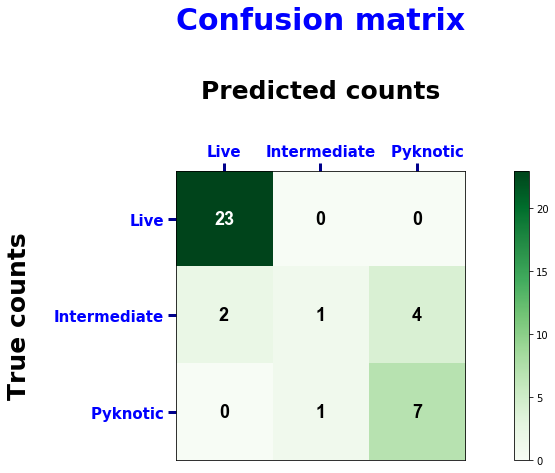

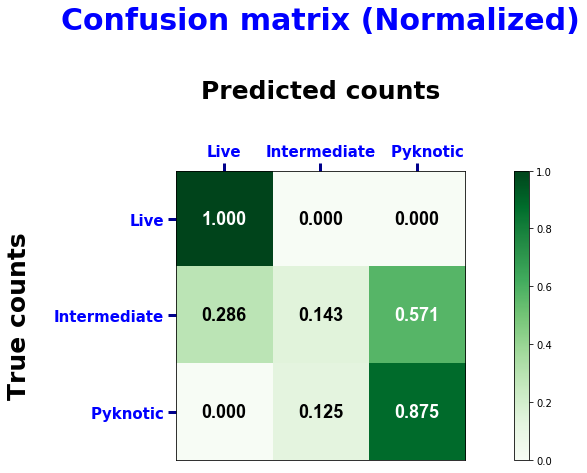

Precision =	 0.7829186602870813
Recall =	 0.8157894736842105
F1_score =	 0.776104185903355
Accuracy =	 0.8157894736842105


In [6]:
############################### Confusion Matrix #####################################
######################################################################################

print(__doc__)
################################# Manually counted ###################################
# GT_N11 = np.array([0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2])
# Detection_N11 = np.array([1,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3])
# GT_C11 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#                    2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])
# Detection_C11 = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#                           0,1,1,1,1,2,3,3,3,3,3,3,0,0,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])
GT_P11 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3])
Detection_P11 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,3,3,3,3,2,3,3,3,3,3,3,3])
######################################################################################

y_test = GT_P11
y_pred = Detection_P11
print(y_test.shape, y_pred.shape)
class_names = ["Live", "Intermediate", "    Pyknotic"]

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Greens):
    if not title:
        if normalize:
            title = "Confusion matrix (Normalized)"
        else:
            title = "Confusion matrix"
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(14,7))
    im = ax.imshow(cm, interpolation = "nearest", cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    
    plt.title(title, fontsize = 30, pad = 50, fontweight = "bold", color = "blue")
    
    ax.set_xlabel("Predicted counts", fontsize = 25, fontweight = "bold")
    ax.set_ylabel("True counts", fontsize = 25, fontweight = "bold")
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_label_coords(0.5, 1.25)
    ax.yaxis.set_label_coords(-0.5, 0.5)

#     plt.setp(ax.get_xticklabels(), rotation = 30, ha = "right", va = "center", rotation_mode = "anchor", style="italic")
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]))
    ax.xaxis.tick_top() 
    ax.set_xticklabels(classes, size = 15, fontweight = "bold", color = "blue")
    ax.set_yticklabels(classes, size = 15, fontweight = "bold", color = "blue")
    ax.xaxis.set_tick_params(color="darkblue", width = 3, length = 8)
    ax.yaxis.set_tick_params(color="darkblue", width = 3, length = 8)

    fmt = ".3f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), dict(size = 18), ha = "center", va = "center", 
                    fontname = "Arial", fontweight = "bold", color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.tight_layout(pad = 200, h_pad = 100, w_pad = 10, rect = (0,0,0.5,0.5))
    return ax

np.set_printoptions(precision = 3)
plot_confusion_matrix(y_test, y_pred, classes = class_names, title = "Confusion matrix")
plot_confusion_matrix(y_test, y_pred, classes = class_names, normalize = True, title = "Confusion matrix (Normalized)")
plt.show()

print("Precision =\t", precision_score(y_test, y_pred, average = "weighted"))
print("Recall =\t", recall_score(y_test, y_pred, average = "weighted"))
print("F1_score =\t", f1_score(y_test, y_pred, average = "weighted"))
print("Accuracy =\t", accuracy_score(y_test, y_pred, normalize = True))